In [1]:
using JLD2
using Statistics
using Printf
using Laplacians
using Plots

In [2]:
sortrows(A, i, rev=false) = sortslices(A, dims=1, lt=(x,y)->isless(x[i],y[i]), rev=rev)

sortrows (generic function with 2 methods)

In [3]:
getValsByTuples(A,ts) = map(t -> getindex(A[t[1],t[2]]),ts)

getValsByTuples (generic function with 1 method)

# load data 

In [4]:
datasets = [
    # unweighted chimera
    "uni_chimera_all.jl.split02merge02.n10000.h1.0.jld2",
    "uni_chimera_all.jl.split02merge02.n100000.h2.0.jld2",
    "uni_chimera_all.jl.split02merge02.n1000000.h4.0.jld2",
    "uni_chimera_all.jl.split02merge02.n10000000.h8.0.jld2",
    # weighted chimera
    "wted_chimera_nopetsc.jl.split02merge02.n10000.h1.0.jld2",
    "wted_chimera_nopetsc.jl.split02merge02.n100000.h2.0.jld2",
    "wted_chimera_nopetsc.jl.split02merge02.n1000000.h4.0.jld2",
    "wted_chimera_nopetsc.jl.split02merge02.n10000000.h8.0.jld2",
    # unweighted boundary chimera
    "uni_bndry_chimera_all.jl.split02merge02.n10000.h1.0.jld2",
    "uni_bndry_chimera_all.jl.split02merge02.n100000.h2.0.jld2",
    "uni_bndry_chimera_all.jl.split02merge02.n1000000.h4.0.jld2",
    "uni_bndry_chimera_all.jl.split02merge02.n10000000.h8.0.jld2",
    # weighted boundary chimera
    "wted_bndry_chimera_nopetsc.jl.split02merge02.n10000.h1.0.jld2",
    "wted_bndry_chimera_nopetsc.jl.split02merge02.n100000.h2.0.jld2",
    "wted_bndry_chimera_nopetsc.jl.split02merge02.n1000000.h4.0.jld2",
    "wted_bndry_chimera_nopetsc.jl.split02merge02.n10000000.h8.0.jld2",
    # max flow 
    "chimeraIPM_nopetsc.jl.split02merge02.jld2",
    "spielmanIPM_all.jl.split02merge02.jld2",
    # Sachdeva star 
    "sachdeva_star_all.jl.split02merge02.jld2",
    # SPE 
    "spe_all.jl.split02merge02.jld2",
    # uniform grid
    "uniform_grid_all.jl.split02merge02.jld2",
    # checkered grid (high contrast grid)
    "checkered_all.jl.split02merge02.jld2",
    # aniso grid 
    "aniso_all.jl.split02merge02.jld2",
    # weighted grid 
    "wgrid_all.jl.split02merge02.jld2",
    # SuiteSparse 
    "suitesparse_all.jl.split02merge02.jld2"
];

In [5]:
function combine(a, b)
    return [a; b]
end

combine (generic function with 1 method)

In [6]:
dic_all = Dict();
for (i, ds) in enumerate(datasets)
    if i == 1
        dic_all = copy(load_object(ds))
    else
        dic = copy(load_object(ds))
        dic_all = merge(combine,dic_all, dic);
    end
end

# scaling, ac, with error exceeded markers

In [10]:
nnz_w_time = [ dic_all["ne"] dic_all["ac_tot"] (dic_all["ac_err"] .> 1e-8) ];
sort_nnz_w_time = sortrows(nnz_w_time,1);

# remove problems that are too small
size_skip = searchsortedfirst(sort_nnz_w_time[:,1], 1000)
@show nnzmin = sort_nnz_w_time[size_skip,1]
@show nnzmax = sort_nnz_w_time[end,1];

data = sort_nnz_w_time[size_skip:end,:];

err_ind = findall(data[:,3] .== 1)

nnzmin = sort_nnz_w_time[size_skip, 1] = 1074.0
nnzmax = sort_nnz_w_time[end, 1] = 2.56000801e8


5-element Vector{Int64}:
 1173
 1202
 1203
 1226
 1238

Here's a plot of t/nnz as a function of nnz (log scale on x-axis)

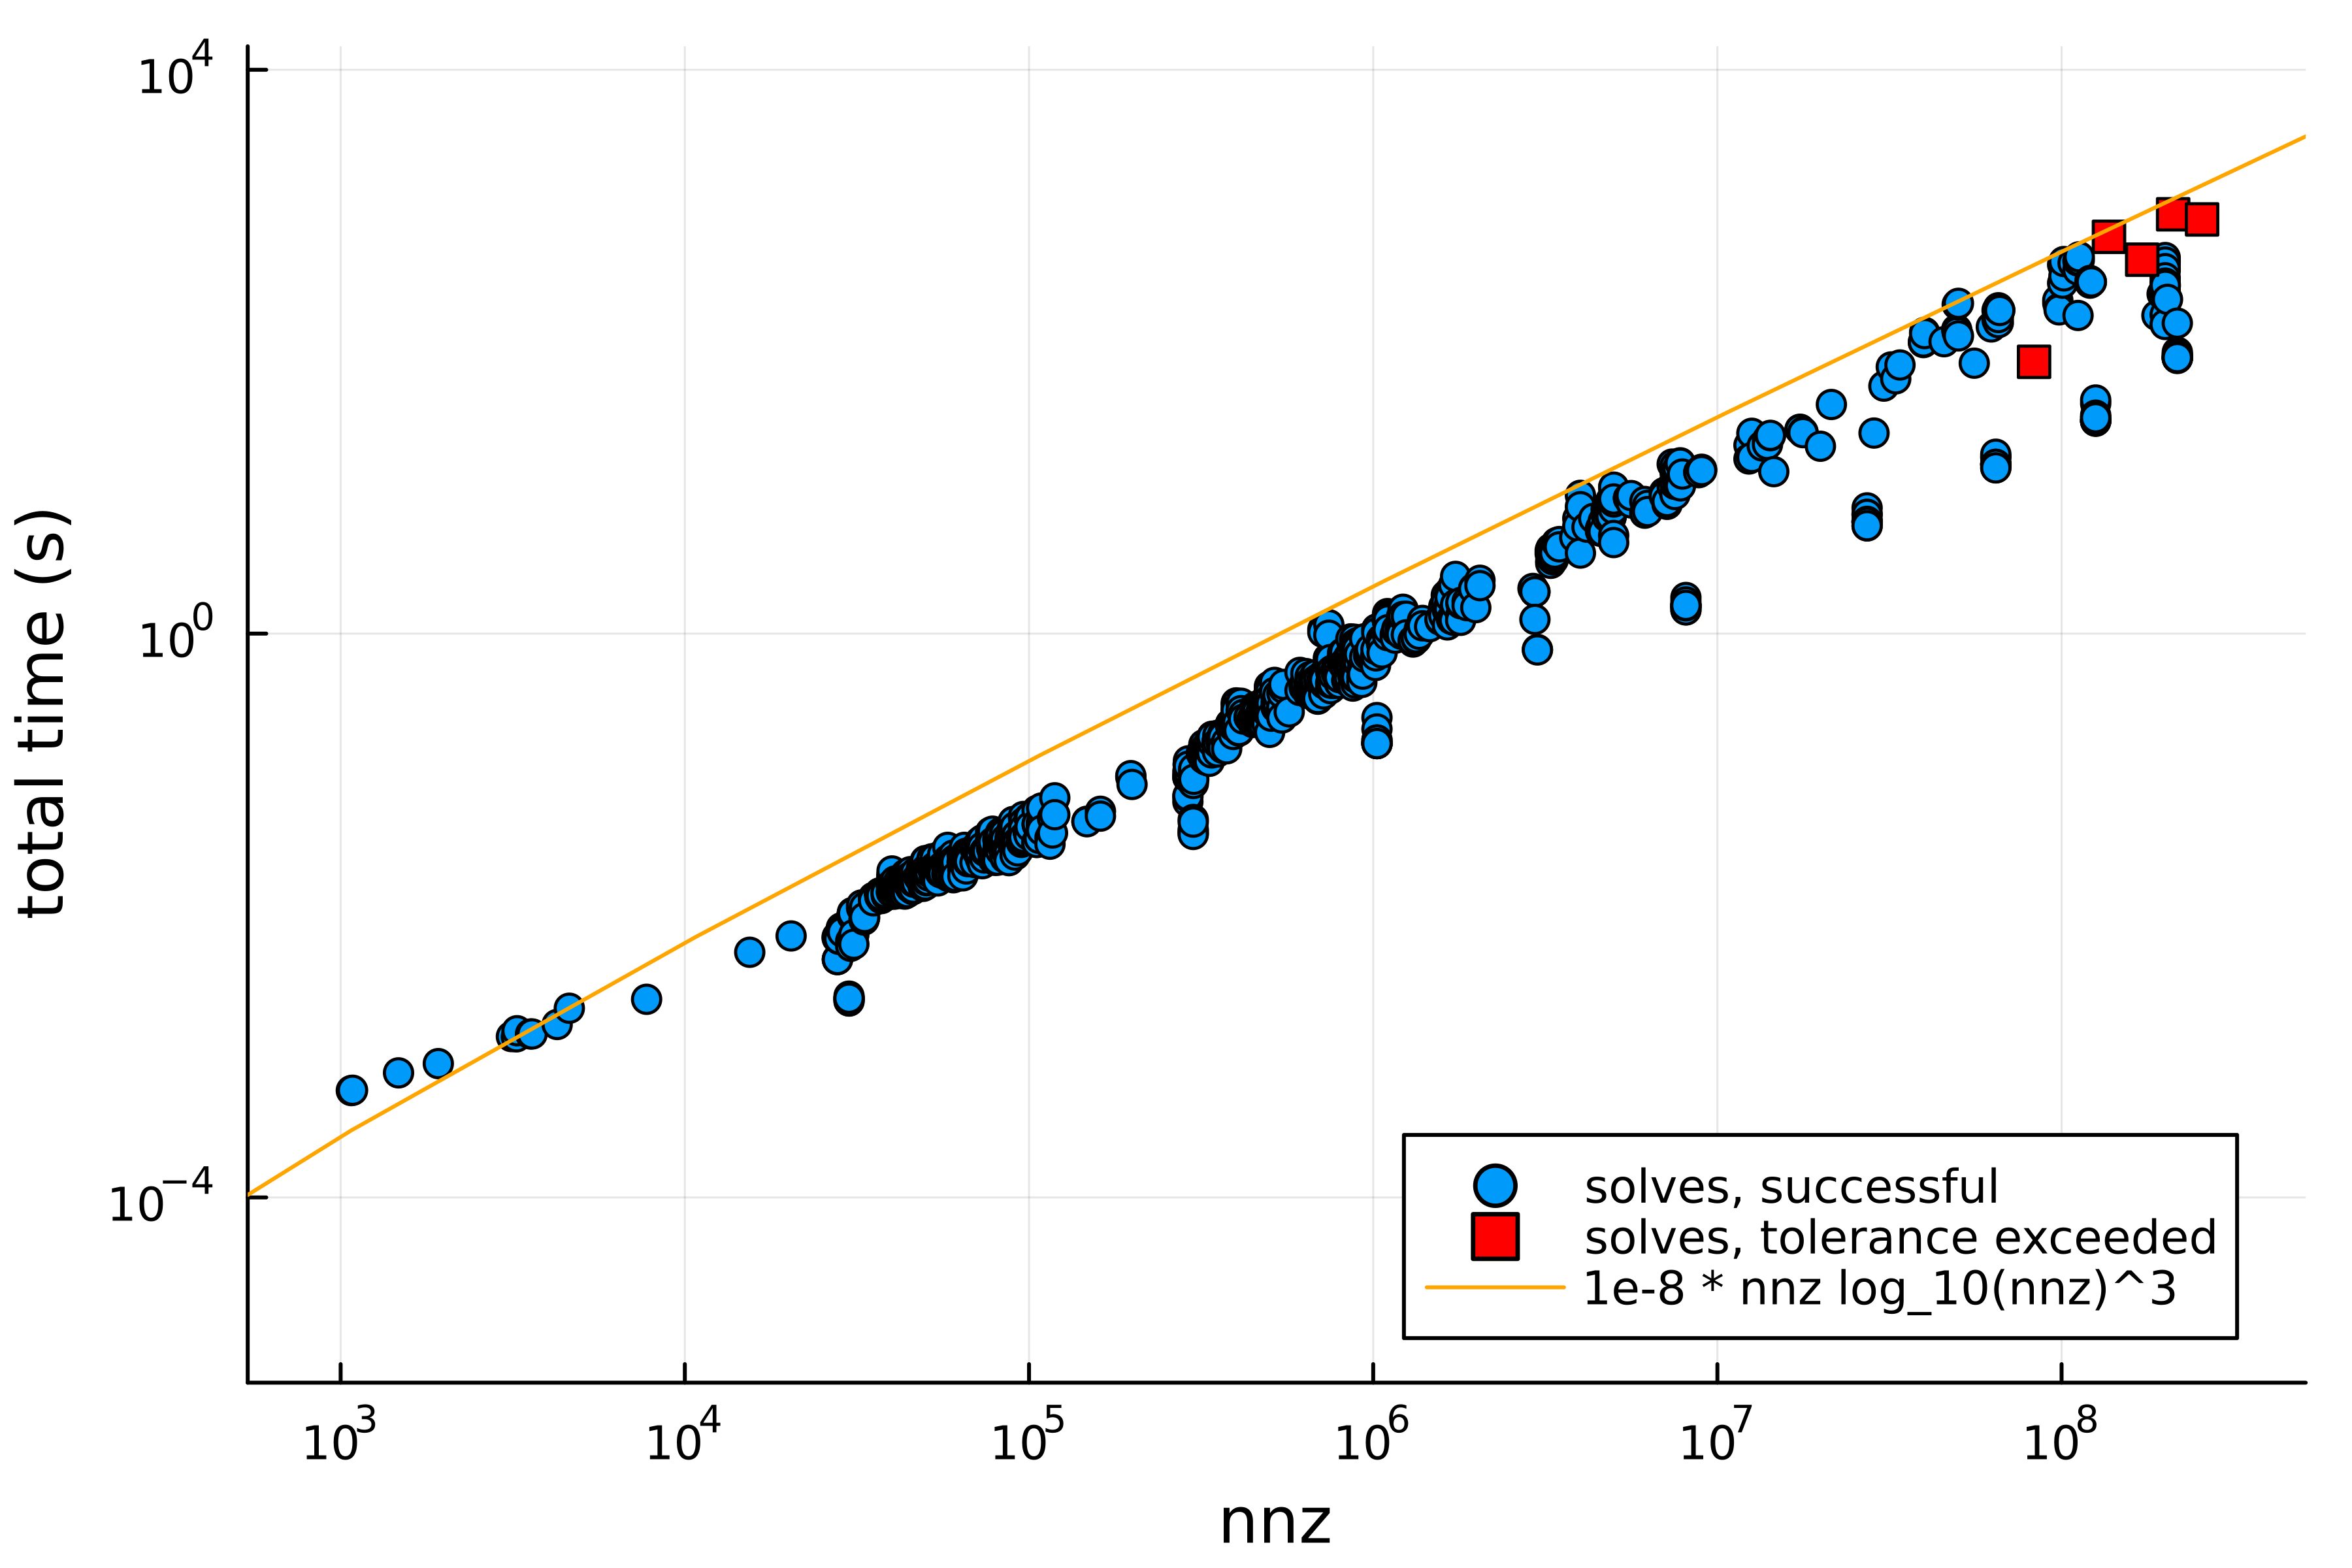

In [11]:
pdata = data
scatter(pdata[:,1],pdata[:,2],
    xaxis =:log,
    yaxis=:log,
    legend=:bottomright,
    xlims=[nnzmin/2,nnzmax*2],
    xticks=[1e3,1e4,1e5,1e6,1e7,1e8],
    yticks=[1e-4,1,1e4],
    label="solves, successful")

scatter!(pdata[err_ind,1],pdata[err_ind,2],
    markershape=:rect,
    markercolor=:red,
    label="solves, tolerance exceeded")

logmin = log10(nnzmin)-1
logmax = log10(nnzmax)+1
pmodelx = [10^i for i = logmin:logmax];
pmodely = [ 1e-8 * 10^i * i^3 for i = logmin:logmax];

plot!(pmodelx,pmodely,xaxis =:log,
    xlabel = "nnz",
    ylabel = "total time (s)",
    label="1e-8 * nnz log_10(nnz)^3 ",
    color =:orange
    )

plot!(dpi=600)
savefig("ac-nnz-vs-time")
plot!()

The simplest plot would just be nnz vs time -- but this doesn't seem that useful w/o a slope estimate. Log scale on both axes.

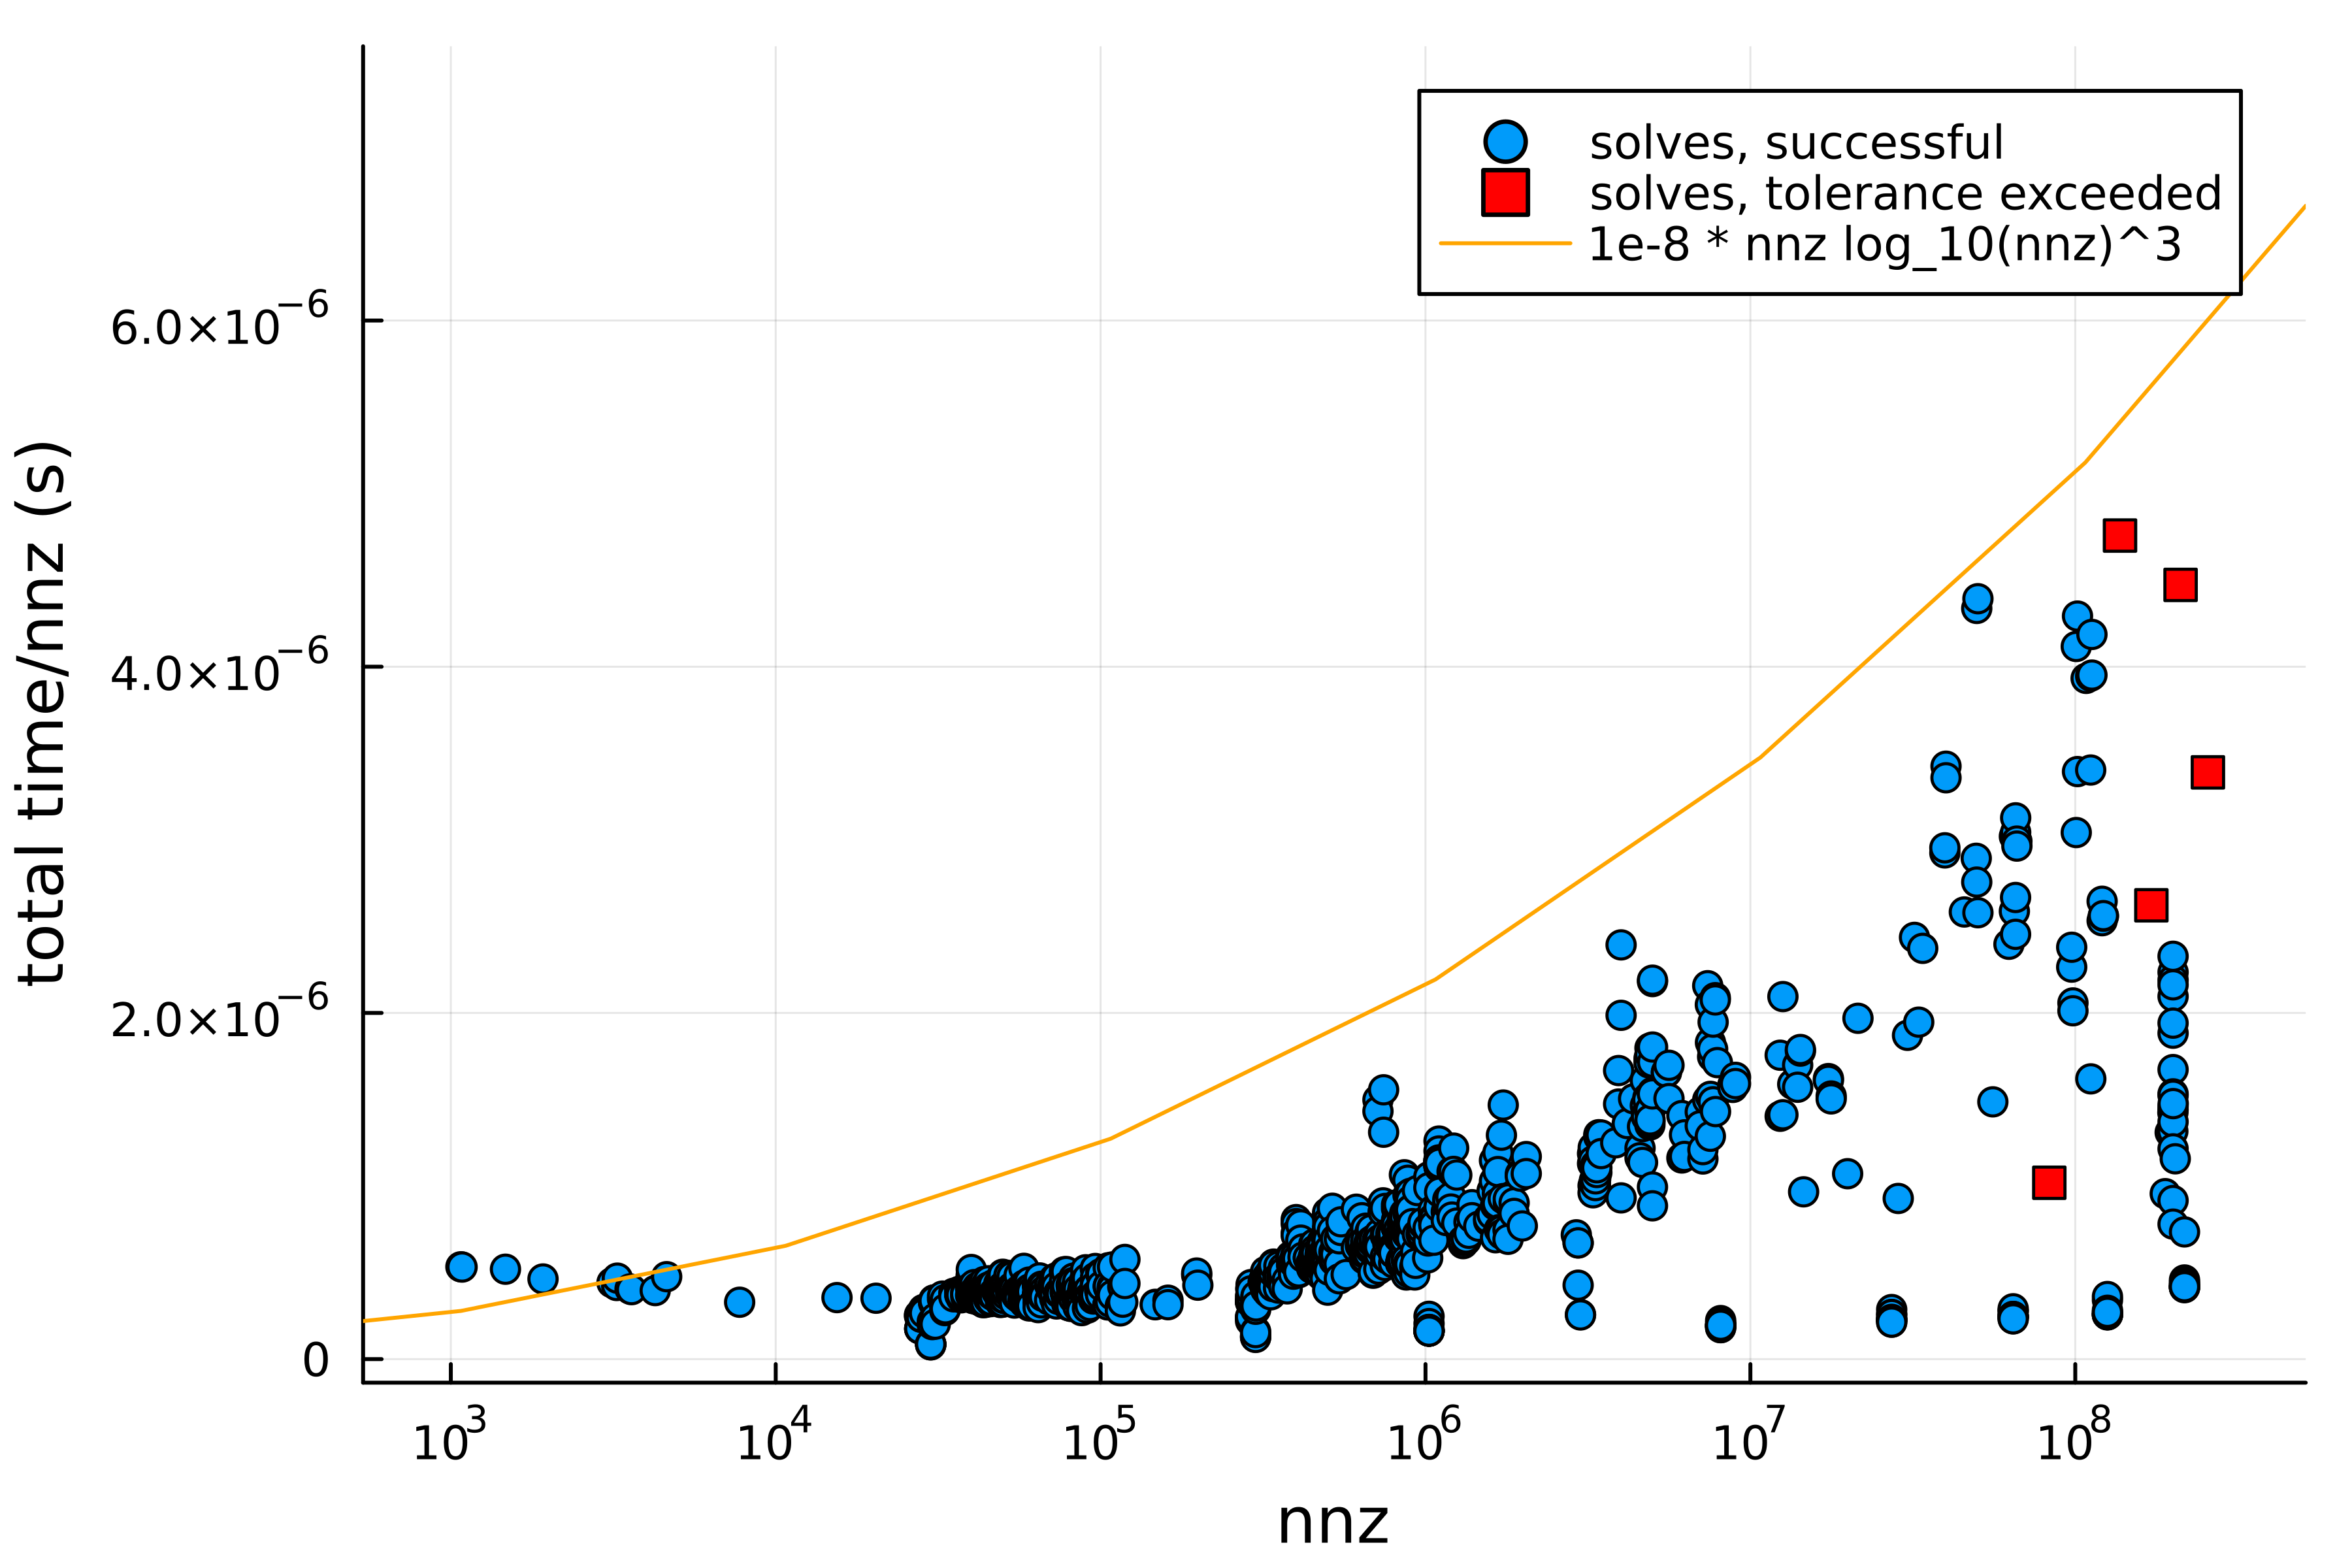

In [12]:
pdata = [ data[:,1]  data[:,2]./ data[:,1] ]
scatter(pdata[:,1],pdata[:,2],
    xaxis =:log,
    legend=:topright,
    xlims=[nnzmin/2,nnzmax*2],
    xticks=[1e3,1e4,1e5,1e6,1e7,1e8],
    label="solves, successful")

scatter!(pdata[err_ind,1],pdata[err_ind,2],
    markershape=:rect,
    markercolor=:red,
    label="solves, tolerance exceeded")

nnzmin = sort_nnz_w_time[size_skip,1]
nnzmax = sort_nnz_w_time[end,1]

logmin = log10(nnzmin)-1
logmax = log10(nnzmax)+1
pmodelx = [10^i for i = logmin:logmax];
pmodely = [ 1e-8 * i^3 for i = logmin:logmax];

plot!(pmodelx,pmodely,
    xlabel = "nnz",
    ylabel = "total time/nnz (s)",
    label="1e-8 * nnz log_10(nnz)^3 ",
    color =:orange
    )

plot!(dpi=600)
savefig("ac-nnz-vs-timebynnz");
plot!()

If O(mlog^3m) is an upper bound, then after dividing by that, we shouldn't see growth. The following plots show the ratio of time by mlog^3m. Log scale on both axes.

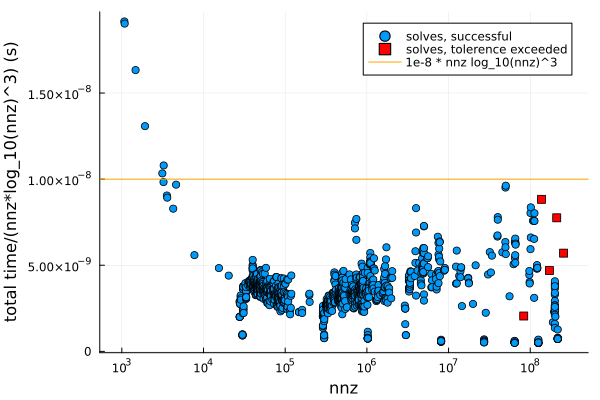

In [13]:
pdata = [ data[:,1] data[:,2]./((x->x*log10(x)^3).(data[:,1])) ]

scatter(pdata[:,1],pdata[:,2],
    xaxis =:log,
    legend=:topright,
    xlims=[nnzmin/2,nnzmax*2],
    xticks=[1e3,1e4,1e5,1e6,1e7,1e8],
    label="solves, successful")

scatter!(pdata[err_ind,1],pdata[err_ind,2],
    markershape=:rect,
    markercolor=:red,
    label="solves, tolerance exceeded")

nnzmin = sort_nnz_w_time[size_skip,1]
nnzmax = sort_nnz_w_time[end,1]

logmin = log10(nnzmin)-1
logmax = log10(nnzmax)+1
pmodelx = [10^i for i = logmin:logmax];
pmodely = [ 1e-8 for i = logmin:logmax];

plot!(pmodelx,pmodely,
    xlabel = "nnz",
    ylabel = "total time/(nnz*log_10(nnz)^3) (s)",
    label="1e-8 * nnz log_10(nnz)^3 ",
    color =:orange
    )

savefig("ac-nnz-vs-timebynnzlog3nnz");
plot!()

# ac2 scaling on all

In [14]:
nnz_w_time = [ dic_all["ne"] dic_all["ac-s2m2_tot"] (dic_all["ac-s2m2_err"] .> 1e-8) ];
sort_nnz_w_time = sortrows(nnz_w_time,1);

# remove problems that are too small
size_skip = searchsortedfirst(sort_nnz_w_time[:,1], 1000)
@show nnzmin = sort_nnz_w_time[size_skip,1]
@show nnzmax = sort_nnz_w_time[end,1];

data = sort_nnz_w_time[size_skip:end,:];

err_ind = findall(data[:,3] .== 1)

nnzmin = sort_nnz_w_time[size_skip, 1] = 1074.0
nnzmax = sort_nnz_w_time[end, 1] = 2.56000801e8


Int64[]

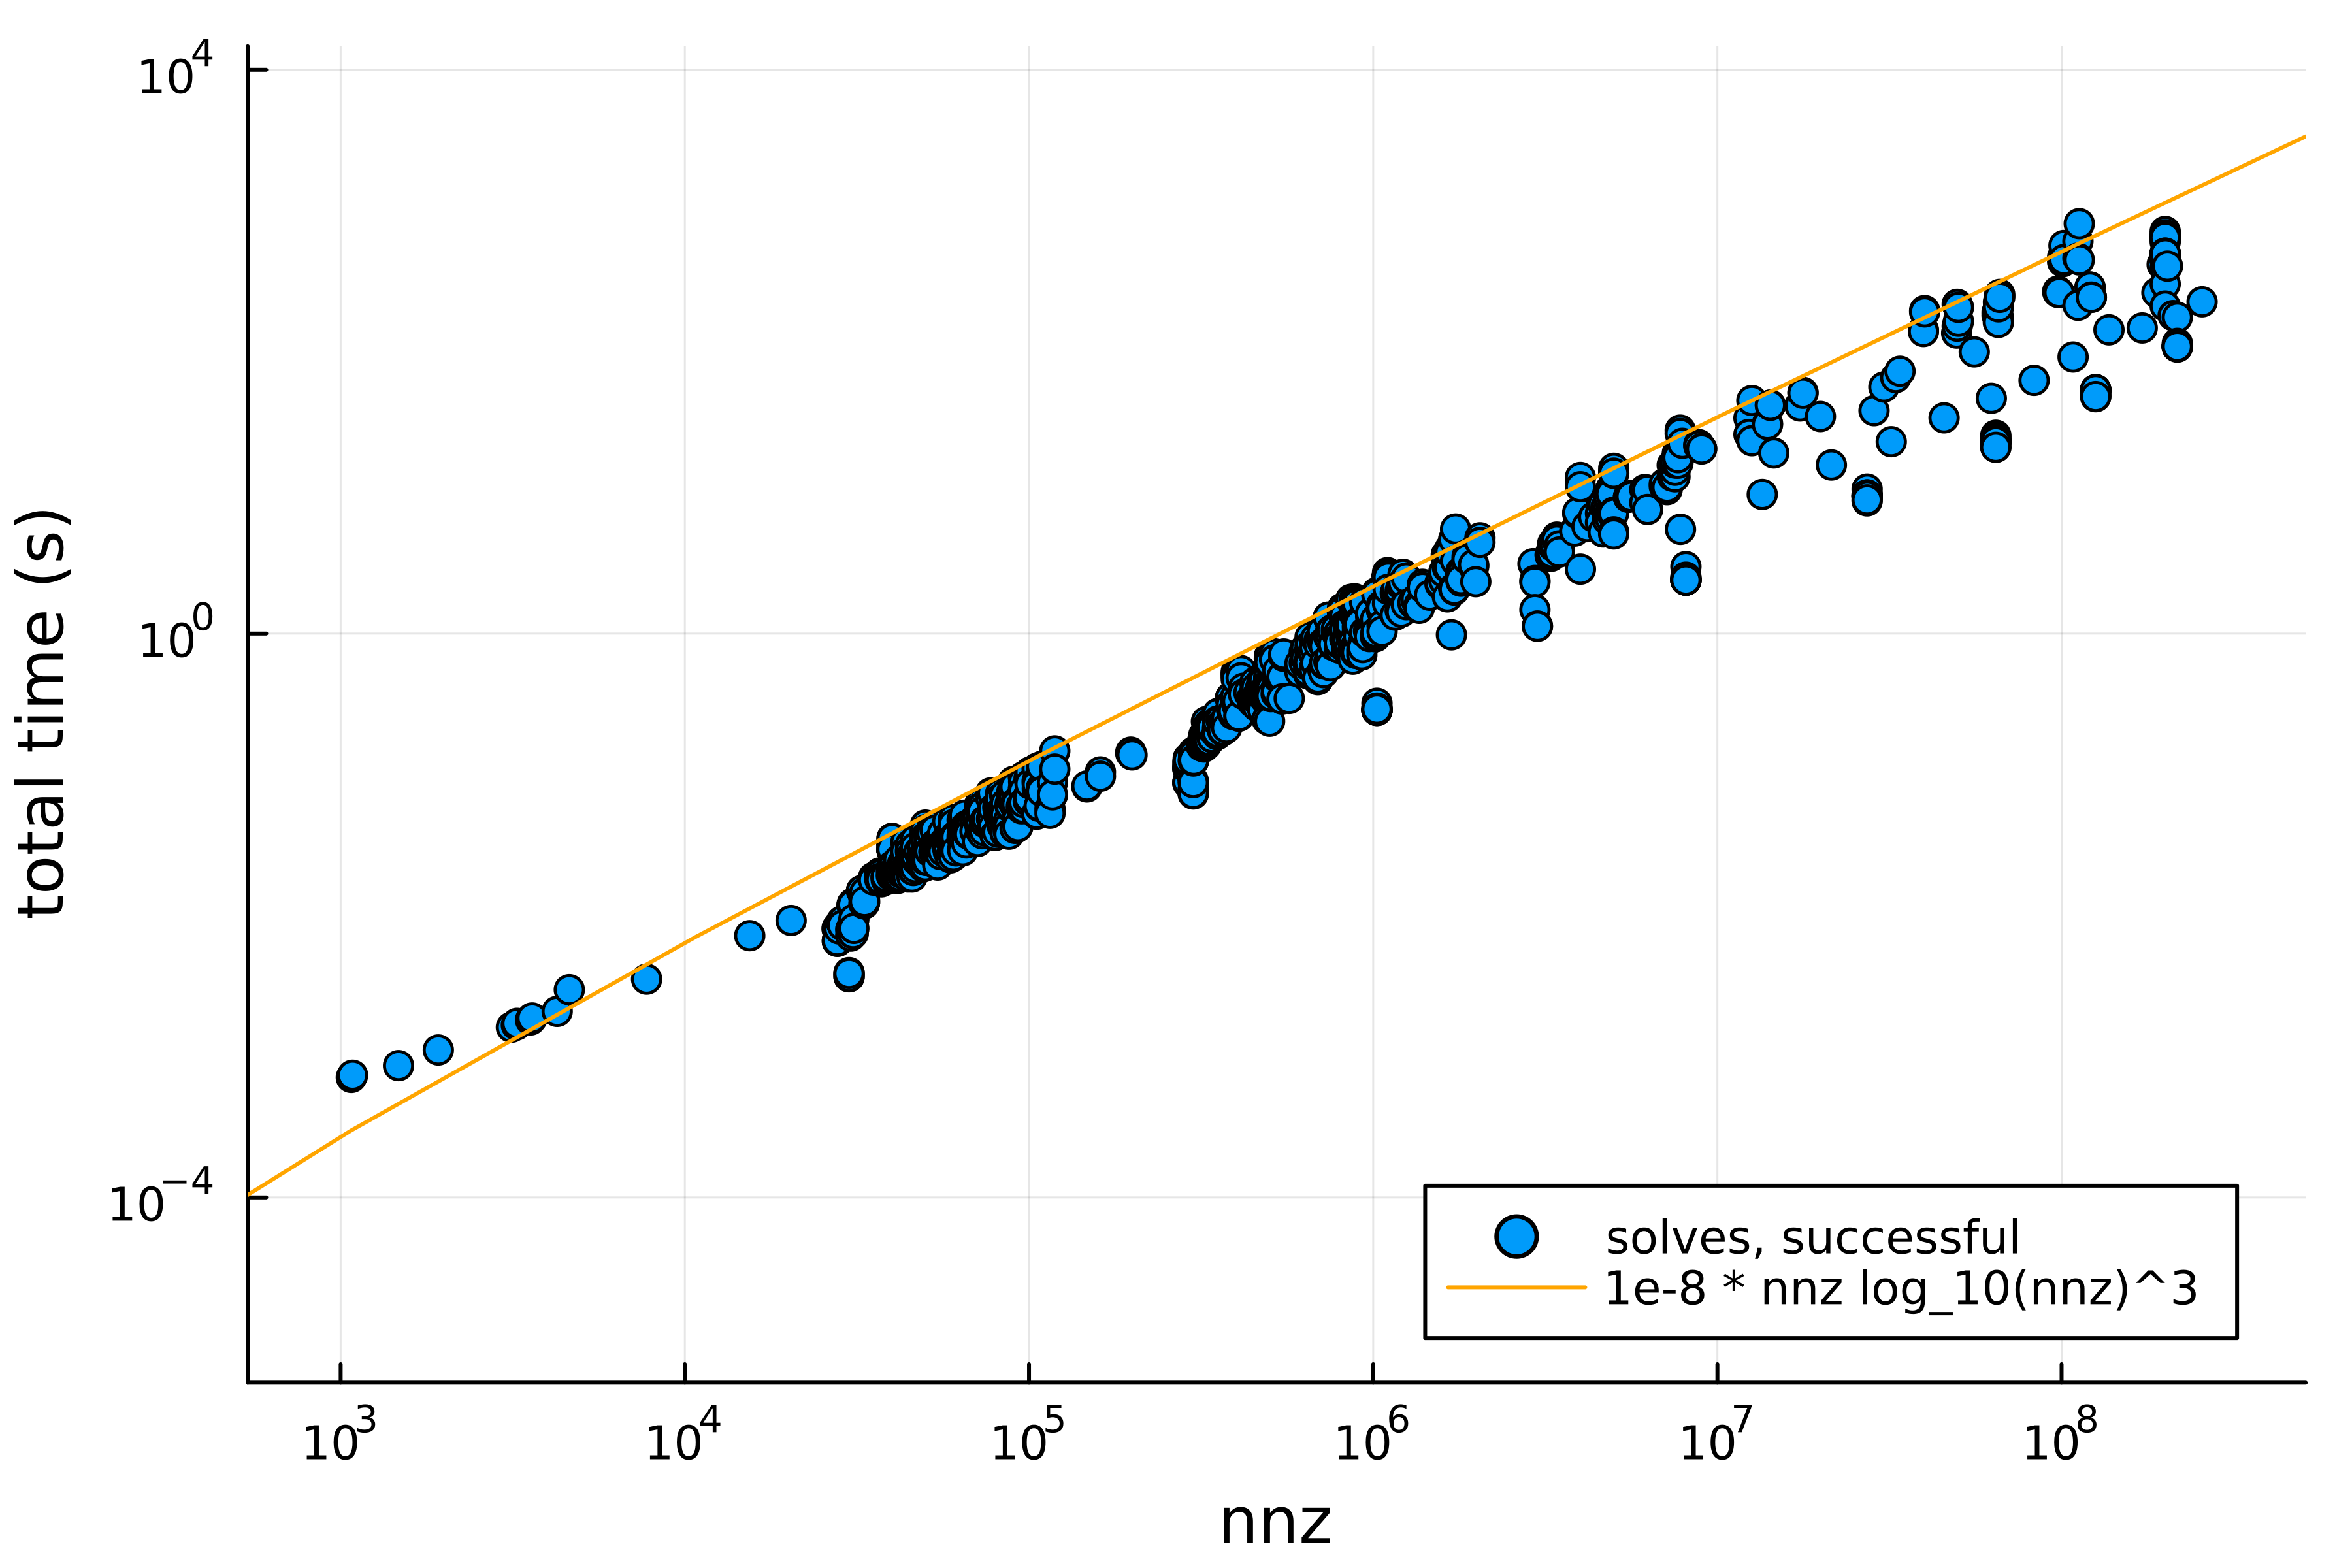

In [15]:
pdata = data
scatter(pdata[:,1],pdata[:,2],
    xaxis =:log,
    yaxis=:log,
    legend=:bottomright,
    xlims=[nnzmin/2,nnzmax*2],
    xticks=[1e3,1e4,1e5,1e6,1e7,1e8],
    yticks=[1e-4,1,1e4],
    label="solves, successful")

logmin = log10(nnzmin)-1
logmax = log10(nnzmax)+1
pmodelx = [10^i for i = logmin:logmax];
pmodely = [ 1e-8 * 10^i * i^3 for i = logmin:logmax];

plot!(pmodelx,pmodely,xaxis =:log,
    xlabel = "nnz",
    ylabel = "total time (s)",
    label="1e-8 * nnz log_10(nnz)^3 ",
    color =:orange
    )

plot!(dpi=600)
savefig("ac2-nnz-vs-time")
plot!()

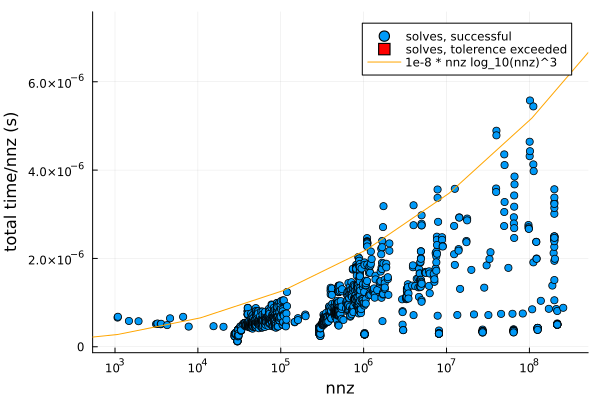

In [13]:
pdata = [ data[:,1]  data[:,2]./ data[:,1] ]
scatter(pdata[:,1],pdata[:,2],
    xaxis =:log,
    legend=:topright,
    xlims=[nnzmin/2,nnzmax*2],
    xticks=[1e3,1e4,1e5,1e6,1e7,1e8],
    label="solves, successful")

scatter!(pdata[err_ind,1],pdata[err_ind,2],
    markershape=:rect,
    markercolor=:red,
    label="solves, tolerance exceeded")

nnzmin = sort_nnz_w_time[size_skip,1]
nnzmax = sort_nnz_w_time[end,1]

logmin = log10(nnzmin)-1
logmax = log10(nnzmax)+1
pmodelx = [10^i for i = logmin:logmax];
pmodely = [ 1e-8 * i^3 for i = logmin:logmax];

plot!(pmodelx,pmodely,
    xlabel = "nnz",
    ylabel = "total time/nnz (s)",
    label="1e-8 * nnz log_10(nnz)^3 ",
    color =:orange
    )

plot!(dpi=600)
savefig("ac2-nnz-vs-timebynnz");
plot!()

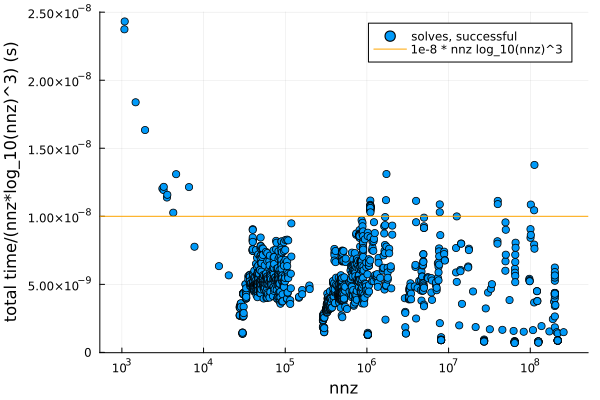

In [14]:
pdata = [ data[:,1] data[:,2]./((x->x*log10(x)^3).(data[:,1])) ]

scatter(pdata[:,1],pdata[:,2],
    xaxis =:log,
    legend=:topright,
    xlims=[nnzmin/2,nnzmax*2],
    xticks=[1e3,1e4,1e5,1e6,1e7,1e8],
    label="solves, successful")

nnzmin = sort_nnz_w_time[size_skip,1]
nnzmax = sort_nnz_w_time[end,1]

logmin = log10(nnzmin)-1
logmax = log10(nnzmax)+1
pmodelx = [10^i for i = logmin:logmax];
pmodely = [ 1e-8 for i = logmin:logmax];

plot!(pmodelx,pmodely,
    xlabel = "nnz",
    ylabel = "total time/(nnz*log_10(nnz)^3) (s)",
    label="1e-8 * nnz log_10(nnz)^3 ",
    color =:orange
    )

savefig("ac2-nnz-vs-timebynnzlog3nnz");
plot!()